# ST2195 Coursework Q5 - Python

# **Use the available variables to construct a model that predicts delays**

### **Import modules**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

sns.set(rc={"figure.dpi":1000, 'savefig.dpi':1000})
sns.set_context('notebook')
sns.set_style("ticks")

import os
os.chdir("C:/Users/Joseph/Downloads/Joshua/SIM Year 2/Programing for Data Science/r/coursework/data")

Load in the data

In [3]:
flight_data = pd.read_csv("flight_data.csv") 

Majority of the data preparation has been done during the earlier stages of the analysis

### **Overview of Delays**      
                       

In [4]:
flight_data.groupby("depdel15")["arrdel15"].value_counts()

depdel15  arrdel15
0         0           23974289
          1            2272590
1         1            4649375
          0             908481
Name: arrdel15, dtype: int64

There is a positive relationship between "DepDel15" and "ArrDel15". Intuitively, delay in arrivals increases when delays on departure increase. Hence, departure delay is a factor in determining arrival delays.

### **Arrival Delay for Unique Carrier**

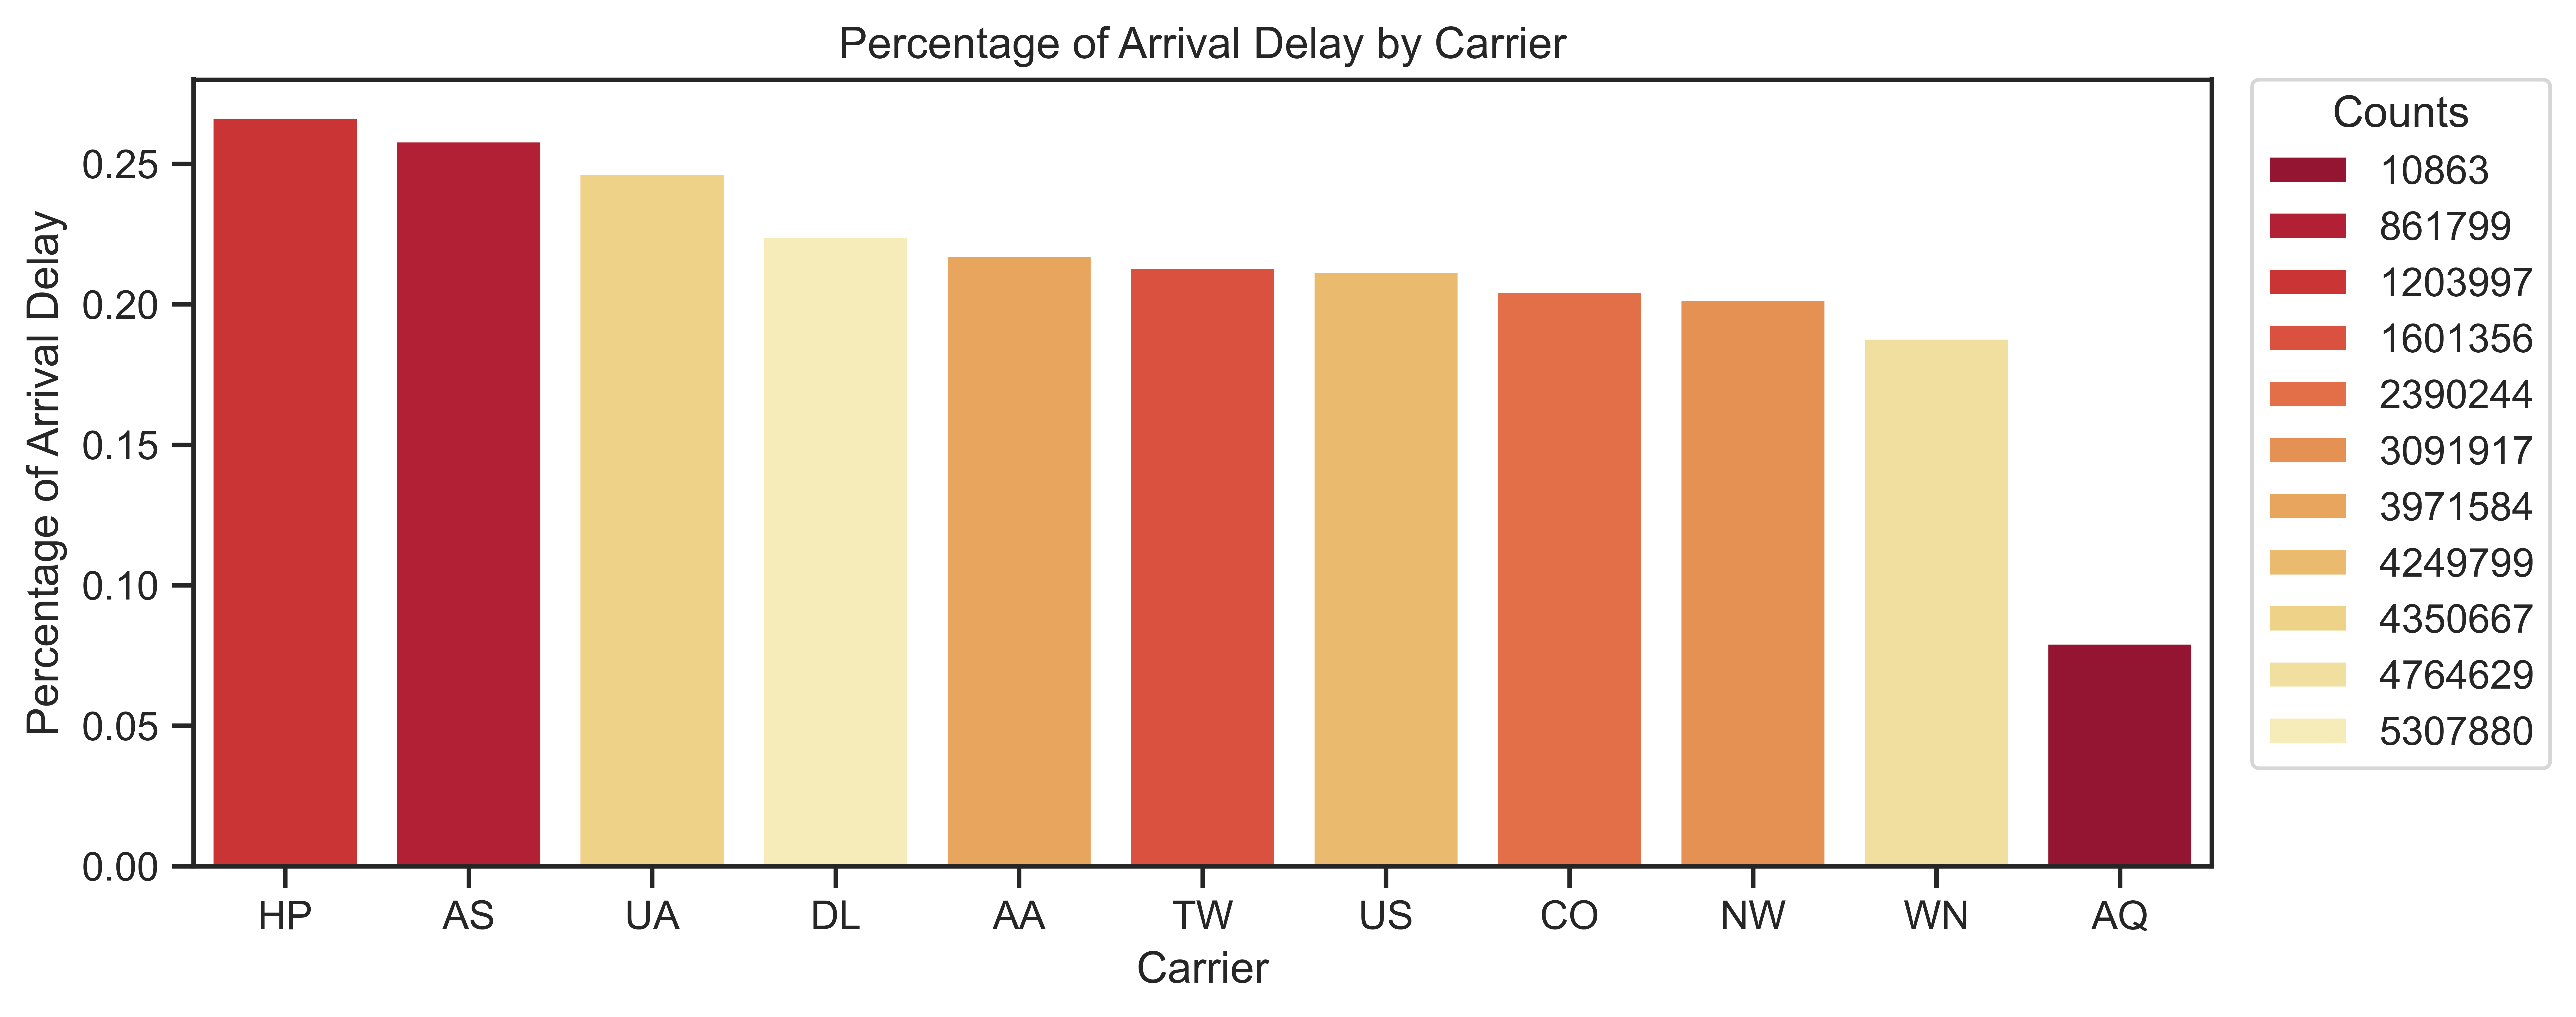

In [5]:
carrier_del = flight_data.groupby("UniqueCarrier")["arrdel15"]\
    .agg(["mean", "count"])\
    .sort_values("mean", ascending = False)\
        .reset_index()

plt.figure(figsize=(10, 4))
c = sns.barplot(data = carrier_del, 
                x = "UniqueCarrier",
                y = "mean",
                dodge = False,
                hue = "count",
                palette = "YlOrRd_r")
c.set(title = "Percentage of Arrival Delay by Carrier",
      xlabel = "Carrier",
      ylabel = "Percentage of Arrival Delay")
plt.legend(bbox_to_anchor = (1.02, 1), 
           loc = 'upper left',
           borderaxespad = 0,
           title = "Counts");

There is no obvious trend between the number of flights and arrival delays. However, by observation, some carriers (darker colored) have a higher percentage of arrival delays even though they rank lower in terms of number of flights. Thus, carrier might be a factor in determining arrival delays.

### **Correlation Analysis**

Before proceeding to the modeling stage:

Check for correlation between the numerical variables of the model data

In [6]:
corr_data = flight_data.drop(
    columns = ["UniqueCarrier", "TailNum", "Origin", "Dest", "flight_date", "season"])

corr_matrix = corr_data.corr()

corr_matrix

Year     Month  DayofMonth  DayOfWeek   DepTime  \
Year               1.000000  0.005636   -0.000163   0.000352  0.001410   
Month              0.005636  1.000000    0.004329   0.000045 -0.002308   
DayofMonth        -0.000163  0.004329    1.000000   0.002100 -0.000506   
DayOfWeek          0.000352  0.000045    0.002100   1.000000  0.005938   
DepTime            0.001410 -0.002308   -0.000506   0.005938  1.000000   
CRSDepTime         0.006338 -0.007221    0.016915   0.005946  0.899402   
ArrTime           -0.011062 -0.002019   -0.001323   0.006131  0.712758   
CRSArrTime         0.002179 -0.008337    0.019047   0.008594  0.706827   
FlightNum          0.086687  0.013512    0.000681   0.005739  0.007830   
ActualElapsedTime  0.060669  0.004981    0.000343   0.006261 -0.030952   
CRSElapsedTime     0.061495  0.007032    0.001249   0.012688 -0.032335   
AirTime            0.046996  0.002574    0.000251   0.008500 -0.041049   
ArrDelay           0.020954 -0.010739    0.005961   0.003915  0.159556   
DepDelay           0.022699 -0.006330    0.008238   0.018770  0.166142   
Distance           0.042759  0.008648    0.001069   0.012797 -0.037978   
TaxiIn             0.063344  0.015560    0.000209   0.012831 -0.019062   
TaxiOut            0.083996  0.010765    0.000543  -0.017909  0.063200   
depdel15           0.027359 -0.003153    0.010184   0.024768  0.203490   
arrdel15           0.022405 -0.008210    0.006925   0.008855  0.163694   

                   CRSDepTime   ArrTime  CRSArrTime  FlightNum  \
Year                 0.006338 -0.011062    0.002179   0.086687   
Month               -0.007221 -0.002019   -0.008337   0.013512   
DayofMonth           0.016915 -0.001323    0.019047   0.000681   
DayOfWeek            0.005946  0.006131    0.008594   0.005739   
DepTime              0.899402  0.712758    0.706827   0.007830   
CRSDepTime           1.000000  0.642338    0.803433  -0.003177   
ArrTime              0.642338  1.000000    0.814578   0.002501   
CRSArrTime           0.803433  0.814578    1.000000  -0.008128   
FlightNum           -0.003177  0.002501   -0.008128   1.000000   
ActualElapsedTime   -0.057642  0.043347    0.014630  -0.140281   
CRSElapsedTime      -0.058733  0.040365    0.013686  -0.142683   
AirTime             -0.064150  0.031657    0.005647  -0.146516   
ArrDelay             0.109741  0.067851    0.102867   0.006280   
DepDelay             0.115703  0.066271    0.107744   0.004158   
Distance            -0.059719  0.029050    0.006806  -0.154522   
TaxiIn              -0.040118  0.031643   -0.000808   0.012252   
TaxiOut              0.039163  0.078487    0.064392  -0.014646   
depdel15             0.149014  0.126647    0.134528   0.003206   
arrdel15             0.117389  0.114114    0.112721   0.000326   

                   ActualElapsedTime  CRSElapsedTime   AirTime  ArrDelay  \
Year                        0.060669        0.061495  0.046996  0.020954   
Month                       0.004981        0.007032  0.002574 -0.010739   
DayofMonth                  0.000343        0.001249  0.000251  0.005961   
DayOfWeek                   0.006261        0.012688  0.008500  0.003915   
DepTime                    -0.030952       -0.032335 -0.041049  0.159556   
CRSDepTime                 -0.057642       -0.058733 -0.064150  0.109741   
ArrTime                     0.043347        0.040365  0.031657  0.067851   
CRSArrTime                  0.014630        0.013686  0.005647  0.102867   
FlightNum                  -0.140281       -0.142683 -0.146516  0.006280   
ActualElapsedTime           1.000000        0.982042  0.987591  0.086170   
CRSElapsedTime              0.982042        1.000000  0.988304  0.001138   
AirTime                     0.987591        0.988304  1.000000  0.035979   
ArrDelay                    0.086170        0.001138  0.035979  1.000000   
DepDelay                    0.034276        0.028159  0.024868  0.840613   
Distance                    0.969710        0.985048  0.982848  0.003463   
TaxiI

In [7]:
# Create mask for lower triangle
mask = np.triu(np.ones_like(corr_matrix))

f, ax = plt.subplots(figsize = (10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr_matrix, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
            square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.4},
            annot = True, annot_kws={"size":8}, fmt = ".2f");

### **Data Modeling**

"features": The list of variables that might be meaningful factors in determining delays

In [8]:
target = flight_data.loc[flight_data.Year == 2000, "arrdel15"].copy()
features = ["season", "UniqueCarrier", "DepTime", "depdel15",
            "ActualElapsedTime", "Distance", "TaxiOut"]  

model_data = flight_data.loc[flight_data.Year == 2000, features].copy()

model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5481303 entries, 26323432 to 31804734
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   season             object 
 1   UniqueCarrier      object 
 2   DepTime            float64
 3   depdel15           int64  
 4   ActualElapsedTime  float64
 5   Distance           float64
 6   TaxiOut            int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 334.6+ MB


Pipeliens: Pre-processing

In [9]:
numerical_features = ["DepTime", "ActualElapsedTime", "Distance", "TaxiOut"]

# Applying SimpleImputer and StandardScaler into a pipeline
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

categorical_features = ["season", "UniqueCarrier", "depdel15"]

# Applying SimpleImputer and StandardScaler into another pipeline
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

data_transformer = ColumnTransformer(
    transformers = [
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)]) 

Get the training and test sets

Set random state for reproducible results

In [10]:
X_train, X_test, y_train, y_test = train_test_split(model_data, target, 
                                                    test_size = 0.5, 
                                                    random_state = 123)

Set up parameters

In [11]:
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'data_transformer__categorical__imputer__strategy': ['constant','most_frequent']
}

### **Logistic Regression**

In [12]:
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression(max_iter = 10000, penalty = 'none'))])
grid_lr = GridSearchCV(pipe_lr, param_grid = param_grid)
grid_lr.fit(X_train, y_train);

### **Gradient Boosting**

In [13]:
pipe_gdb = Pipeline(steps=[('data_transformer', data_transformer),
       ('pipe_gdb',GradientBoostingClassifier(random_state = 2))])

grid_gdb = GridSearchCV(pipe_gdb, param_grid = param_grid)
grid_gdb.fit(X_train, y_train);

### **Random Forest**

In [14]:
pipe_rf = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_rf', RandomForestClassifier(random_state = 0))])
grid_rf = GridSearchCV(pipe_rf, param_grid = param_grid)
grid_rf.fit(X_train, y_train);

### **Classification Tree**

In [15]:
pipe_tree = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_tree', DecisionTreeClassifier(random_state = 0))])
grid_tree = GridSearchCV(pipe_tree, param_grid = param_grid)
grid_tree.fit(X_train, y_train);

### **Compare the performance of the classification models by the ROC curve**

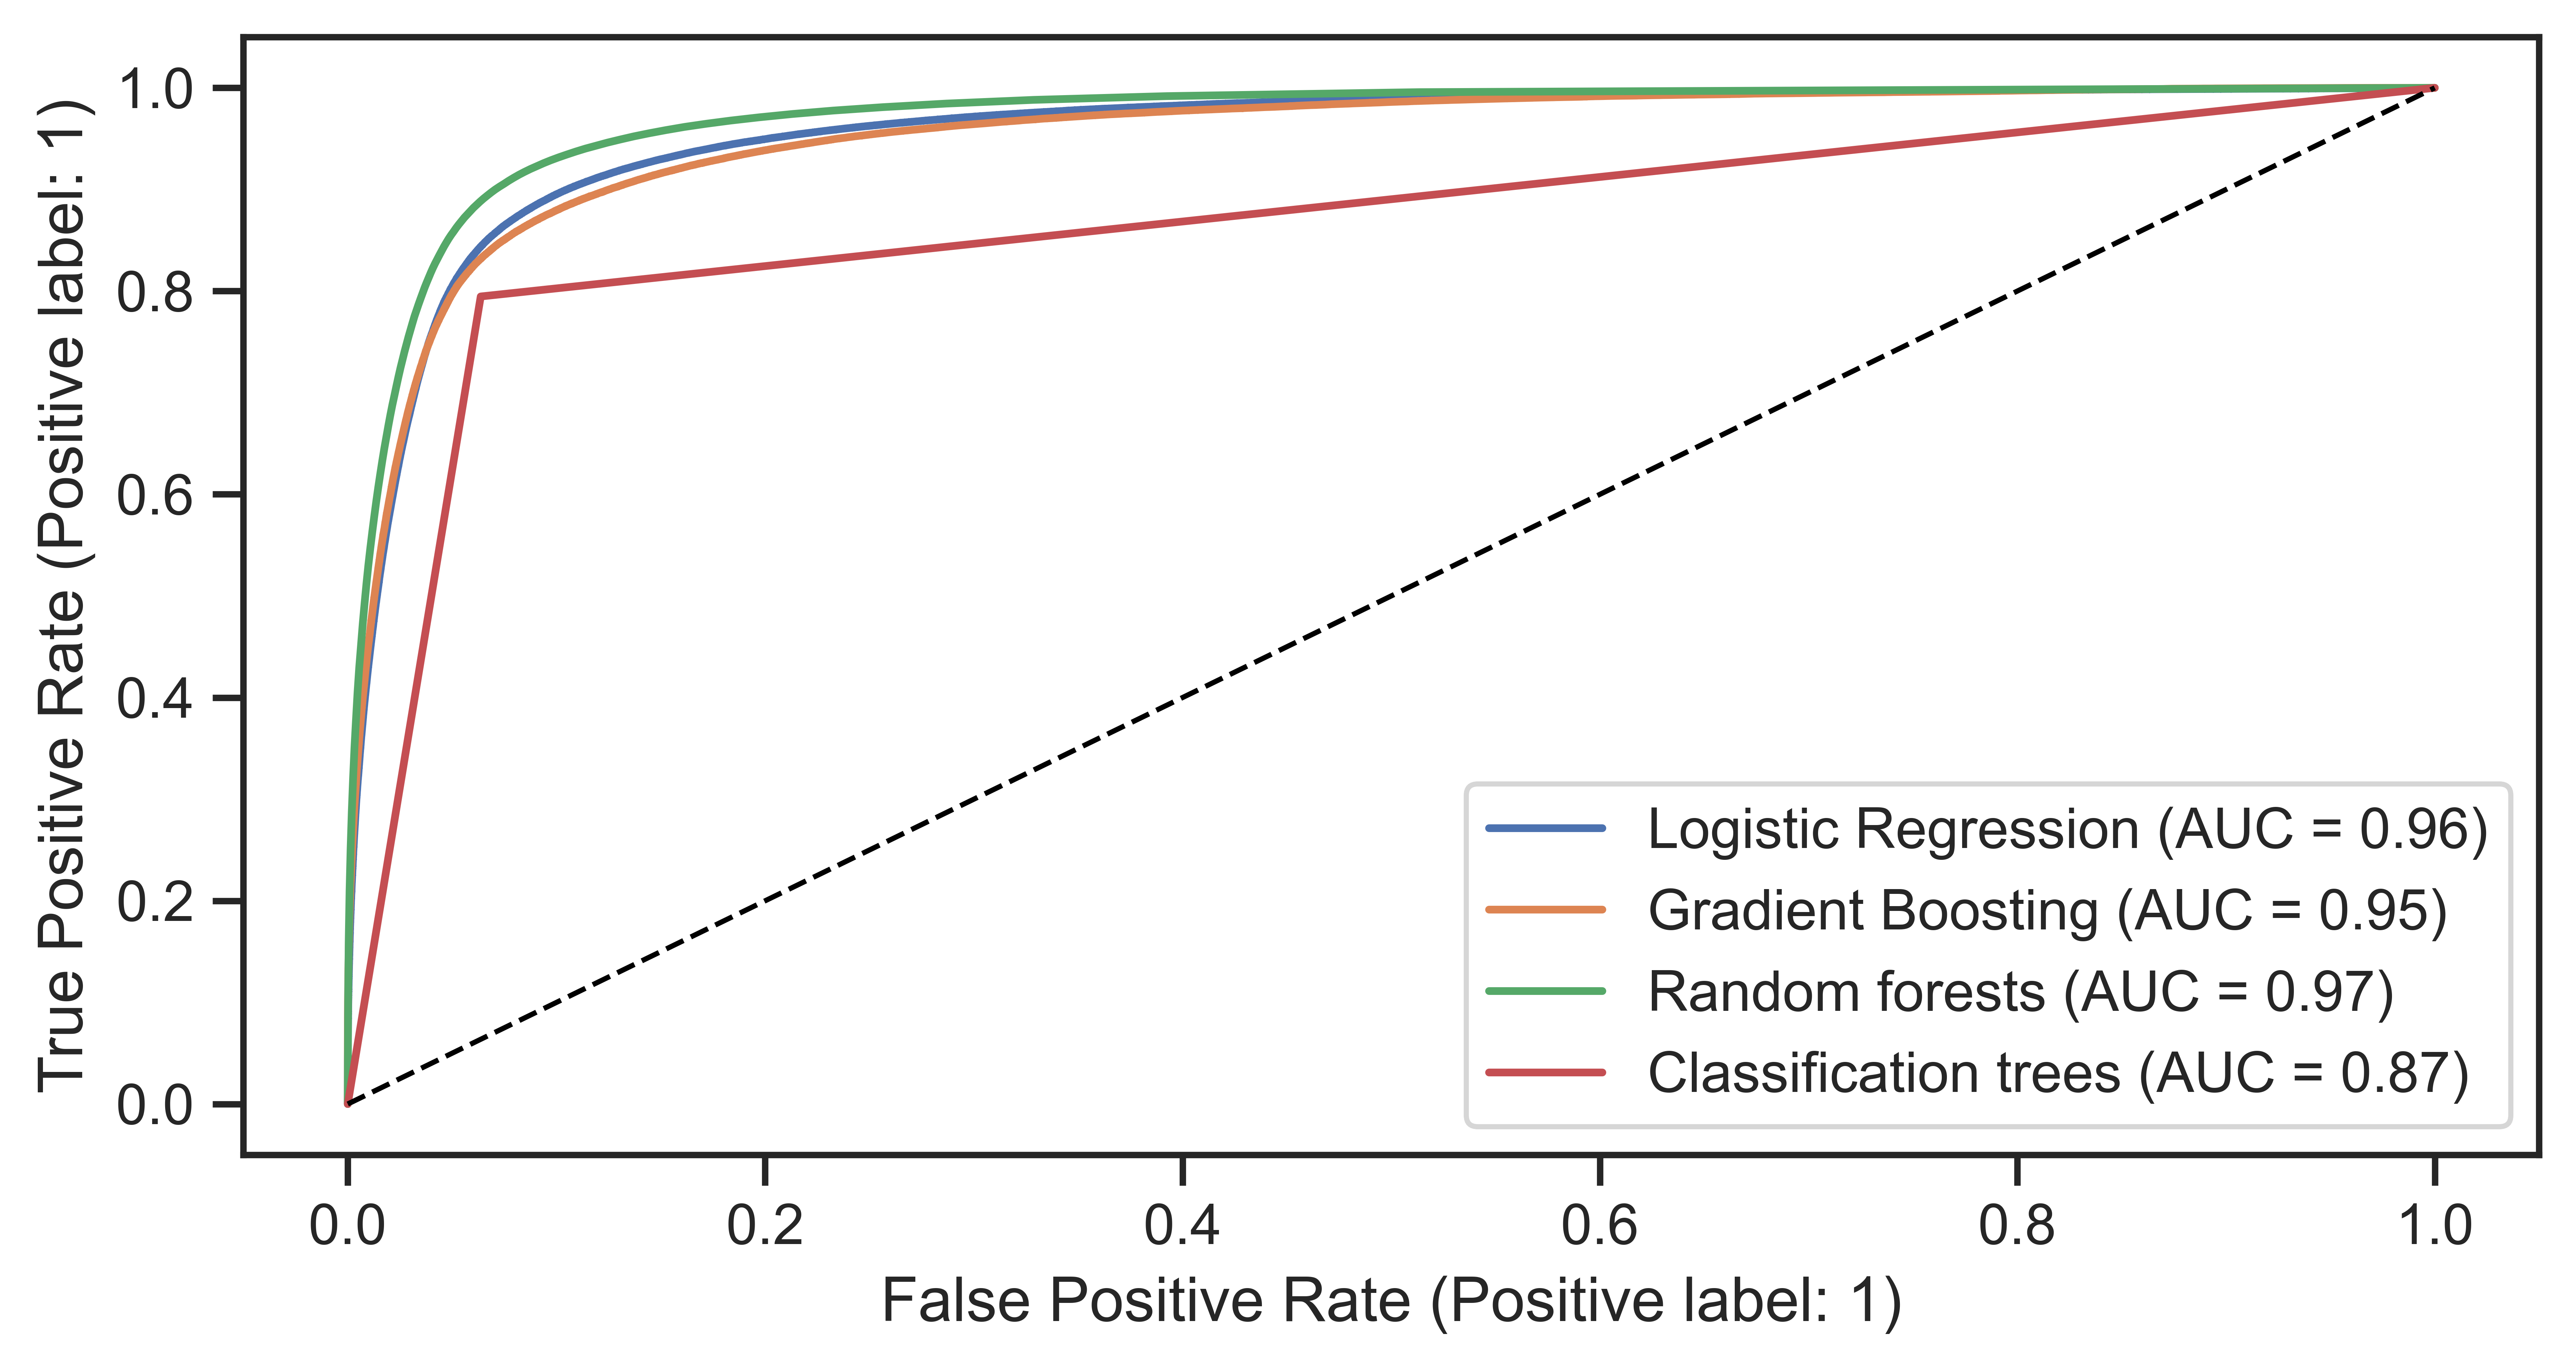

In [16]:
plt.figure(figsize=(8, 4))
ax = plt.gca()

plot_roc_curve(grid_lr, X_test, y_test, ax = ax, name = 'Logistic Regression')
plot_roc_curve(grid_gdb, X_test, y_test, ax = ax, name = 'Gradient Boosting')
plot_roc_curve(grid_rf, X_test, y_test, ax = ax, name = 'Random forests')
plot_roc_curve(grid_tree, X_test, y_test, ax = ax, name = 'Classification trees')
plt.plot([0, 1], [0, 1], color = 'black', lw = 1, linestyle = '--')
plt.show()

The ROC curve depicts the trade-off between the "True Positive Rate" and "1 - False Positive Rate". The distance between the curve and the upper-left corner indicates the efficiency of the classifiers. The shorter the distance, the higher the accuracy and the better the performance.

Overall, "Random Forest" has the highest accuracy in predicting delays. Hence, "Random Forest" is the better model out of the three.